# Raisin Classification with CNN and Model Boosting

This notebook trains a Convolutional Neural Network (CNN) on the raisin dataset for multi-class classification. To boost performance, we use data augmentation, dropout, and callbacks like early stopping.

Dataset: 3 classes with 960 images each.

In [2]:
# Install TensorFlow if needed
# !pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-10-24 09:39:46.706890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 09:39:46.753078: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 09:39:46.966825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 09:39:46.966946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 09:39:47.002811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# Data preparation
data_dir = 'RAISIN-DATASET'

# Data augmentation for boosting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),  # Assuming images are ~150x150; adjust if needed
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print('Class indices:', train_generator.class_indices)

Found 2304 images belonging to 3 classes.
Found 576 images belonging to 3 classes.
Class indices: {'RAISIN_BLACK': 0, 'RAISIN_GRADE1': 1, 'RAISIN_PREMIUM': 2}


In [4]:
# Model building
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for boosting (regularization)
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

2025-10-24 09:39:49.180950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-24 09:39:49.782271: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Callbacks for boosting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
72/72 [==============================] - 14s 196ms/step - loss: 0.3434 - accuracy: 0.8090 - val_loss: 0.6074 - val_accuracy: 0.6927 - lr: 2.5000e-04
Epoch 2/30
72/72 [==============================] - 14s 194ms/step - loss: 0.3289 - accuracy: 0.8281 - val_loss: 0.5352 - val_accuracy: 0.7240 - lr: 2.5000e-04
Epoch 3/30
72/72 [==============================] - 14s 194ms/step - loss: 0.3172 - accuracy: 0.8281 - val_loss: 0.5518 - val_accuracy: 0.6806 - lr: 2.5000e-04
Epoch 4/30
72/72 [==============================] - 14s 193ms/step - loss: 0.3169 - accuracy: 0.8303 - val_loss: 0.7826 - val_accuracy: 0.7118 - lr: 2.5000e-04
Epoch 5/30
72/72 [==============================] - 14s 194ms/step - loss: 0.3129 - accuracy: 0.8329 - val_loss: 0.5525 - val_accuracy: 0.7014 - lr: 2.5000e-04
Epoch 6/30
72/72 [==============================] - 14s 192ms/step - loss: 0.2926 - accuracy: 0.8433 - val_loss: 0.6957 - val_accuracy: 0.6858 - lr: 2.5000e-04
Epoch 7/30
72/72 [======================

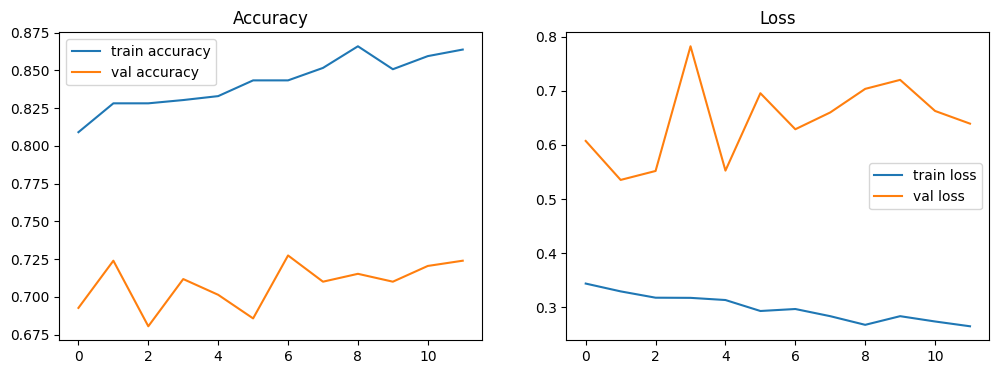

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

18/18 [==============================] - 2s 115ms/step


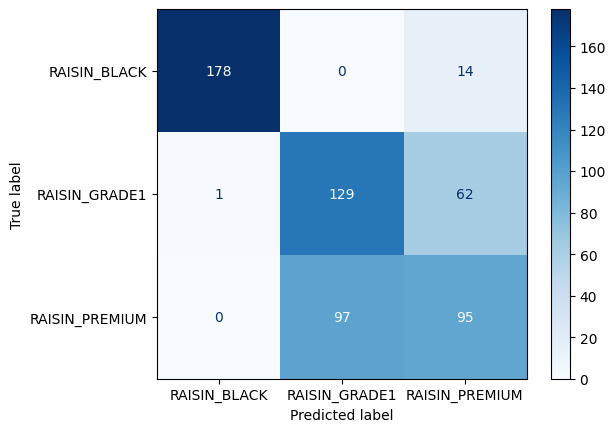

18/18 [==============================] - 2s 116ms/step - loss: 0.5301 - accuracy: 0.7049
Validation Accuracy: 0.7048611044883728


In [12]:
# Evaluation: Confusion Matrix
validation_generator.reset()
val_preds = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
val_pred_classes = np.argmax(val_preds, axis=1)
val_labels = validation_generator.classes

cm = confusion_matrix(val_labels, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Validation Accuracy:', model.evaluate(validation_generator)[1])

In [13]:
# Export the model
model.save('raisin_cnn_model.h5')
print('Model saved as raisin_cnn_model.h5')

Model saved as raisin_cnn_model.h5


/home/ronnie-allen/Documents/food-pro/jenifer/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test the exported model

1/1 [==============================] - 0s 49ms/step
Predicted class: RAISIN_BLACK
Confidence: 0.9999


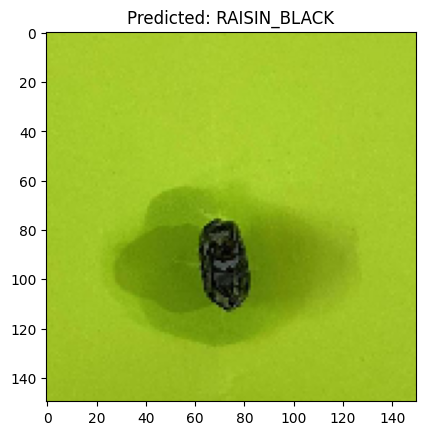

In [9]:
# Prediction on a sample image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load saved model
loaded_model = load_model('raisin_cnn_model.h5')

# Load and preprocess an image (replace with your image path)
img_path = 'RAISIN-DATASET/RAISIN_BLACK/RAISIN_BLACK_1.jpg'  # Example image
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = loaded_model.predict(img_array)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(predictions)]

print(f'Predicted class: {predicted_class}')
print(f'Confidence: {np.max(predictions):.4f}')

# Display image
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.show()